###  IMPORT LIBRARIES

In [49]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import lightgbm as lgb
import optuna
import joblib

### 2. LOAD DATA

In [50]:
X = np.load('../output/X_train.npy')
y = np.load('../output/y_train.npy')

print("Feature shape:", X.shape)
print("Target shape :", y.shape)

Feature shape: (64374, 15)
Target shape : (64374,)


### 3. TRAIN AND VALIDATION SETUP

In [51]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

joblib.dump((X_val, y_val), "val_data.joblib")

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)

Train size: (51499, 15)
Validation size: (12875, 15)


### Define Optuna objective function for LightGBM

In [52]:
def objective(trial):
    # Hyperparameters
    param = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 5.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 5.0),
        "random_state": 42,
        "n_estimators": 1000,
    }

    model = lgb.LGBMClassifier(**param)

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="auc",
        callbacks=[lgb.early_stopping(stopping_rounds=10)]
    )

    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)
    return auc


### 5. RUN OPTUNA MODEL

In [53]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best AUC:", study.best_value)
print("Best Parameters:", study.best_params)

[I 2025-07-19 02:09:51,801] A new study created in memory with name: no-name-73bbf6df-009b-4208-8890-ab97b8e929d2
d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:09:51,955] Trial 0 finished with value: 0.9935557956256208 and parameters: {'learning_rate': 0.0015949249868431321, 'num_leaves': 149, 'max_depth': 4, 'feature_fraction': 0.46792888374231034, 'bagging_fraction': 0.496870232270728, 'bagging_freq': 4, 'lambda_l1': 4.171675967238099, 'lambda_l2': 3.752404060499587}. Best is trial 0 with value: 0.9935557956256208.


[LightGBM] [Warning] feature_fraction is set=0.46792888374231034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46792888374231034
[LightGBM] [Warning] lambda_l1 is set=4.171675967238099, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.171675967238099
[LightGBM] [Warning] lambda_l2 is set=3.752404060499587, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.752404060499587
[LightGBM] [Warning] bagging_fraction is set=0.496870232270728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.496870232270728
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.46792888374231034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46792888374231034
[LightGBM] [Warning] lambda_l1 is set=4.171675967238099, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.171675967238099
[LightGBM] [Warning] lambda_l2 is set=3.7

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:09:52,063] Trial 1 finished with value: 0.9991502613411569 and parameters: {'learning_rate': 0.026134760212775797, 'num_leaves': 88, 'max_depth': 12, 'feature_fraction': 0.7096952261596089, 'bagging_fraction': 0.870517547297903, 'bagging_freq': 8, 'lambda_l1': 2.072820634055857, 'lambda_l2': 3.3496991124147044}. Best is trial 1 with value: 0.9991502613411569.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[9]	valid_0's auc: 0.99915	valid_0's binary_logloss: 0.550733
[LightGBM] [Warning] feature_fraction is set=0.7096952261596089, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7096952261596089
[LightGBM] [Warning] lambda_l1 is set=2.072820634055857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.072820634055857
[LightGBM] [Warning] lambda_l2 is set=3.3496991124147044, reg_lambda=0.0 will be ignored. Cur

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:09:53,012] Trial 2 finished with value: 0.9999865704657102 and parameters: {'learning_rate': 0.046787871485957026, 'num_leaves': 109, 'max_depth': 3, 'feature_fraction': 0.7275533273898471, 'bagging_fraction': 0.49501650466812575, 'bagging_freq': 3, 'lambda_l1': 4.752489830540706, 'lambda_l2': 2.019401529997738}. Best is trial 2 with value: 0.9999865704657102.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:09:53,341] Trial 3 finished with value: 0.9999600743575165 and parameters: {'learning_rate': 0.2250519837587367, 'num_leaves': 105, 'max_depth': 15, 'feature_fraction': 0.4234030182771895, 'bagging_fraction': 0.40863065857374326, 'bagging_freq': 10, 'lambda_l1': 0.15551053619896726, 'lambda_l2': 3.636045381457571}. Best is trial 2 with value: 0.9999865704657102.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[70]	valid_0's auc: 0.99996	valid_0's binary_logloss: 0.0354025
[LightGBM] [Warning] feature_fraction is set=0.4234030182771895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4234030182771895
[LightGBM] [Warning] lambda_l1 is set=0.15551053619896726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15551053619896726
[LightGBM] [Warning] lambda_l2 is set=3.636045381457571, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.636045381457571
[LightGBM] [Warning] bagging_fraction is set=0.40863065857374326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40863065857374326
[LightGBM] [Warning] bagging_fr

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:09:54,469] Trial 4 finished with value: 0.9999998306184864 and parameters: {'learning_rate': 0.05649326813884962, 'num_leaves': 101, 'max_depth': 3, 'feature_fraction': 0.8064514313121993, 'bagging_fraction': 0.9343981740377397, 'bagging_freq': 4, 'lambda_l1': 4.764930148249312, 'lambda_l2': 2.6816277075698656}. Best is trial 4 with value: 0.9999998306184864.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:09:54,584] Trial 5 finished with value: 0.9979108605103552 and parameters: {'learning_rate': 0.0010997801357626607, 'num_leaves': 74, 'max_depth': 9, 'feature_fraction': 0.5002494057587158, 'bagging_fraction': 0.9773354944261092, 'bagging_freq': 3, 'lambda_l1': 3.981426318974594, 'lambda_l2': 3.390543673892108}. Best is trial 4 with value: 0.9999998306184864.
d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:09:54,688] Trial 6 finished with value: 0.9977928741874769 and parameters: {'learning_rate': 0.016815300441506604, 'num_leaves': 22, 'max_depth': 15, 'feature_fraction': 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[12]	valid_0's auc: 0.997911	valid_0's binary_logloss: 0.686034
[LightGBM] [Warning] feature_fraction is set=0.5002494057587158, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5002494057587158
[LightGBM] [Warning] lambda_l1 is set=3.981426318974594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.981426318974594
[LightGBM] [Warning] lambda_l2 is set=3.390543673892108, reg_lambda=0.0 will be ignored. Cu

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:09:55,083] Trial 7 finished with value: 0.9999141719673401 and parameters: {'learning_rate': 0.19623156867059086, 'num_leaves': 40, 'max_depth': 3, 'feature_fraction': 0.4431546870809373, 'bagging_fraction': 0.9568088075160902, 'bagging_freq': 3, 'lambda_l1': 1.0363393711662012, 'lambda_l2': 2.2237999137160678}. Best is trial 4 with value: 0.9999998306184864.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:09:55,328] Trial 8 finished with value: 0.9999999999999999 and parameters: {'learning_rate': 0.21288492313415516, 'num_leaves': 100, 'max_depth': 14, 'feature_fraction': 0.9988471375448404, 'bagging_fraction': 0.8632129818892398, 'bagging_freq': 3, 'lambda_l1': 3.3810086419410377, 'lambda_l2': 0.3634327725091918}. Best is trial 8 with value: 0.9999999999999999.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:09:55,425] Trial 9 finished with value: 0.9947109533507825 and parameters: {'learning_rate': 0.0016479816113944437, 'num_leaves': 26, 'max_depth': 4, 'feature_fraction': 0.7081250872847002, 'bagging_fraction': 0.902732294955921, 'bagging_freq': 5, 'lambda_l1': 3.3629102514795277, 'lambda_l2': 2.7920637532488906}. Best is trial 8 with value: 0.9999999999999999.
d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:09:55,542] Trial 10 finished with value: 0.9994098627080561 and parameters: {'learning_rate': 0.006090968260353169, 'num_leaves': 136, 'max_depth': 9, 'feature_fraction': 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[16]	valid_0's auc: 0.994711	valid_0's binary_logloss: 0.674513
[LightGBM] [Warning] feature_fraction is set=0.7081250872847002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7081250872847002
[LightGBM] [Warning] lambda_l1 is set=3.3629102514795277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3629102514795277
[LightGBM] [Warning] lambda_l2 is set=2.7920637532488906, reg_lambda=0.0 will be ignored.

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:09:56,014] Trial 11 finished with value: 0.9999999032105636 and parameters: {'learning_rate': 0.08584410844367771, 'num_leaves': 67, 'max_depth': 7, 'feature_fraction': 0.9870152750294607, 'bagging_fraction': 0.6685363736026888, 'bagging_freq': 1, 'lambda_l1': 2.8293296897509794, 'lambda_l2': 0.7779882396685603}. Best is trial 8 with value: 0.9999999999999999.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:09:56,399] Trial 12 finished with value: 1.0 and parameters: {'learning_rate': 0.10596198613881479, 'num_leaves': 56, 'max_depth': 7, 'feature_fraction': 0.9933059627875545, 'bagging_fraction': 0.6525159443194917, 'bagging_freq': 1, 'lambda_l1': 2.676592466136273, 'lambda_l2': 0.22473163876908597}. Best is trial 12 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:09:56,642] Trial 13 finished with value: 1.0 and parameters: {'learning_rate': 0.29373585962407667, 'num_leaves': 52, 'max_depth': 12, 'feature_fraction': 0.8872340441233426, 'bagging_fraction': 0.6633466641812096, 'bagging_freq': 1, 'lambda_l1': 1.8589078758127298, 'lambda_l2': 4.85719808711487}. Best is trial 12 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.8872340441233426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8872340441233426
[LightGBM] [Warning] lambda_l1 is set=1.8589078758127298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8589078758127298
[LightGBM] [Warning] lambda_l2 is set=4.85719808711487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.85719808711487
[LightGBM] [Warning] bagging_fraction is set=0.6633466641812096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6633466641812096
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 24394, number of negative: 27105
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 48

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:09:56,998] Trial 14 finished with value: 0.9999997822237683 and parameters: {'learning_rate': 0.1042395240479118, 'num_leaves': 52, 'max_depth': 12, 'feature_fraction': 0.871800715926811, 'bagging_fraction': 0.6530385690630053, 'bagging_freq': 1, 'lambda_l1': 1.7868312674801479, 'lambda_l2': 4.766258074651892}. Best is trial 12 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:09:57,242] Trial 15 finished with value: 1.0 and parameters: {'learning_rate': 0.28586891756413035, 'num_leaves': 52, 'max_depth': 7, 'feature_fraction': 0.8886106248056252, 'bagging_fraction': 0.5902435278395026, 'bagging_freq': 2, 'lambda_l1': 1.3333141710393819, 'lambda_l2': 1.1795033310884522}. Best is trial 12 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:09:57,388] Trial 16 finished with value: 0.9979995680287457 and parameters: {'learning_rate': 0.010379307522153807, 'num_leaves': 62, 'max_depth': 11, 'feature_fraction': 0.5933600687158275, 'bagging_fraction': 0.7591069597235127, 'bagging_freq': 6, 'lambda_l1': 0.6986553340940092, 'lambda_l2': 4.612731758173289}. Best is trial 12 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[12]	valid_0's auc: 0.998	valid_0's binary_logloss: 0.631878
[LightGBM] [Warning] feature_fraction is set=0.5933600687158275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5933600687158275


d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:09:57,799] Trial 17 finished with value: 0.9999999274079228 and parameters: {'learning_rate': 0.10366522866473687, 'num_leaves': 46, 'max_depth': 6, 'feature_fraction': 0.8969093370052017, 'bagging_fraction': 0.5910239931392864, 'bagging_freq': 2, 'lambda_l1': 1.9294733442718854, 'lambda_l2': 1.5509255828752706}. Best is trial 12 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[117]	valid_0's auc: 1	valid_0's binary_logloss: 0.00518522
[LightGBM] [Warning] feature_fraction is set=0.8969093370052017, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8969093370052017
[LightGBM] [Warning] lambda_l1 is set=1.9294733442718854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9294733442718854
[LightGBM] [Warning] lambda_l2 is set=1.5509255828752706, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5509255828752706
[LightGBM] [Warning] bagging_fraction is set=0.5910239931392864, subsample=1.0 will be ignored. Current value

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:09:58,650] Trial 18 finished with value: 0.9999996370396138 and parameters: {'learning_rate': 0.03940567306169856, 'num_leaves': 79, 'max_depth': 10, 'feature_fraction': 0.8266015925391912, 'bagging_fraction': 0.7488666434506656, 'bagging_freq': 5, 'lambda_l1': 3.0457942501828015, 'lambda_l2': 4.209699343217371}. Best is trial 12 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.8266015925391912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8266015925391912
[LightGBM] [Warning] lambda_l1 is set=3.0457942501828015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0457942501828015
[LightGBM] [Warning] lambda_l2 is set=4.209699343217371, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.209699343217371
[LightGBM] [Warning] bagging_fraction is set=0.7488666434506656, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7488666434506656
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7880656619217355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7880656619217355
[LightGBM] [Warning] lambda_l1 is set=2.355248434026454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.355248434026454
[LightGBM] [Warning] lambda_l2 is set=1.4

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:09:58,999] Trial 19 finished with value: 0.9999999516052818 and parameters: {'learning_rate': 0.15202801213166856, 'num_leaves': 40, 'max_depth': 13, 'feature_fraction': 0.7880656619217355, 'bagging_fraction': 0.5870104121303591, 'bagging_freq': 10, 'lambda_l1': 2.355248434026454, 'lambda_l2': 1.4605846274456753}. Best is trial 12 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:09:59,145] Trial 20 finished with value: 0.9989385707452381 and parameters: {'learning_rate': 0.005523423495551542, 'num_leaves': 33, 'max_depth': 8, 'feature_fraction': 0.9327415138372669, 'bagging_fraction': 0.6886419447869616, 'bagging_freq': 2, 'lambda_l1': 1.1997108821807567, 'lambda_l2': 4.998407052355795}. Best is trial 12 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.9327415138372669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9327415138372669
[LightGBM] [Warning] lambda_l1 is set=1.1997108821807567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1997108821807567
[LightGBM] [Warning] lambda_l2 is set=4.998407052355795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.998407052355795
[LightGBM] [Warning] bagging_fraction is set=0.6886419447869616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6886419447869616
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9327415138372669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9327415138372669
[LightGBM] [Warning] lambda_l1 is set=1.1997108821807567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1997108821807567
[LightGBM] [Warning] lambda_l2 is set=4

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:09:59,357] Trial 21 finished with value: 1.0 and parameters: {'learning_rate': 0.2991432128017263, 'num_leaves': 60, 'max_depth': 6, 'feature_fraction': 0.9007288158146143, 'bagging_fraction': 0.578276442405199, 'bagging_freq': 2, 'lambda_l1': 1.4375221760268997, 'lambda_l2': 0.8366040908039434}. Best is trial 12 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:09:59,725] Trial 22 finished with value: 1.0 and parameters: {'learning_rate': 0.12655484872905157, 'num_leaves': 54, 'max_depth': 7, 'feature_fraction': 0.8514297033919761, 'bagging_fraction': 0.5350302300670844, 'bagging_freq': 1, 'lambda_l1': 1.6572225375090268, 'lambda_l2': 0.9616970114584519}. Best is trial 12 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:09:59,963] Trial 23 finished with value: 1.0 and parameters: {'learning_rate': 0.28558358429880043, 'num_leaves': 73, 'max_depth': 6, 'feature_fraction': 0.9350450559651269, 'bagging_fraction': 0.630127325766772, 'bagging_freq': 2, 'lambda_l1': 0.6496217533480233, 'lambda_l2': 1.4276731423425826}. Best is trial 12 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:10:00,110] Trial 24 finished with value: 0.9989638085907594 and parameters: {'learning_rate': 0.08012418314539914, 'num_leaves': 84, 'max_depth': 10, 'feature_fraction': 0.6330089758881716, 'bagging_fraction': 0.7203610724643732, 'bagging_freq': 1, 'lambda_l1': 2.2928642673830266, 'lambda_l2': 0.4547385302345912}. Best is trial 12 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[12]	valid_0's auc: 0.998964	valid_0's binary_logloss: 0.369203
[LightGBM] [Warning] feature_fraction is set=0.6330089758881716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6330089758881716
[LightGBM] [Warning] lambda_l1 is set=2.2928642673830266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2928642673830266
[LightGBM] [Warning] lambda_l2 is set=0.4547385302345912, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4547385302345912
[LightGBM] [Warning] bagging_fraction is set=0.7203610724643732, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7203610724643732
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7589891758565659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7589891758565

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:10:00,492] Trial 25 finished with value: 0.9999997822237683 and parameters: {'learning_rate': 0.15443534723168098, 'num_leaves': 49, 'max_depth': 7, 'feature_fraction': 0.7589891758565659, 'bagging_fraction': 0.7962353437305465, 'bagging_freq': 4, 'lambda_l1': 2.8302437624804284, 'lambda_l2': 1.107609207556136}. Best is trial 12 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:10:01,004] Trial 26 finished with value: 1.0 and parameters: {'learning_rate': 0.06770197425011579, 'num_leaves': 37, 'max_depth': 5, 'feature_fraction': 0.9306007406790385, 'bagging_fraction': 0.628073833466074, 'bagging_freq': 2, 'lambda_l1': 0.902233939579633, 'lambda_l2': 0.03363039503545484}. Best is trial 12 with value: 1.0.
d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:10:01,150] Trial 27 finished with value: 0.9988144745891917 and parameters: {'learning_rate': 0.028636565186141893, 'num_leaves': 61, 'max_depth': 8, 'feature_fraction': 0.6551130252920128, 'bagging_fr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[162]	valid_0's auc: 1	valid_0's binary_logloss: 0.00488724
[LightGBM] [Warning] feature_fraction is set=0.9306007406790385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9306007406790385
[LightGBM] [Warning] lambda_l1 is set=0.902233939579633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.902233939579633
[LightGBM] [Warning] lambda_l2 is set=0.03363039503545484, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03363039503545484
[LightGBM] [Warning] bagging_fraction is set=0.628073833466074, subsample=1.0 will be ignored. Current value:

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:10:01,382] Trial 28 finished with value: 1.0 and parameters: {'learning_rate': 0.20266558797523546, 'num_leaves': 29, 'max_depth': 10, 'feature_fraction': 0.8627307663971578, 'bagging_fraction': 0.5297474115006251, 'bagging_freq': 8, 'lambda_l1': 1.4485940023345116, 'lambda_l2': 0.5283719673373034}. Best is trial 12 with value: 1.0.


[LightGBM] [Warning] feature_fraction is set=0.8627307663971578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8627307663971578
[LightGBM] [Warning] lambda_l1 is set=1.4485940023345116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4485940023345116
[LightGBM] [Warning] lambda_l2 is set=0.5283719673373034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5283719673373034
[LightGBM] [Warning] bagging_fraction is set=0.5297474115006251, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5297474115006251
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8627307663971578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8627307663971578
[LightGBM] [Warning] lambda_l1 is set=1.4485940023345116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4485940023345116
[LightGBM] [Warning] lambda_l2 is set

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-19 02:10:01,706] Trial 29 finished with value: 0.9999998064211274 and parameters: {'learning_rate': 0.14328421619519346, 'num_leaves': 122, 'max_depth': 8, 'feature_fraction': 0.9684277779520434, 'bagging_fraction': 0.47392463703672066, 'bagging_freq': 4, 'lambda_l1': 3.5093982860198096, 'lambda_l2': 1.2043403645538586}. Best is trial 12 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

### Train Final Model with Best Hyperparameters

In [54]:
# Retrieve the best parameters
best_params = study.best_params

# Train model using best parameters
final_model = lgb.LGBMClassifier(**best_params, random_state=42)

final_model.fit(X_train, y_train)


[LightGBM] [Warning] feature_fraction is set=0.9933059627875545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9933059627875545
[LightGBM] [Warning] lambda_l1 is set=2.676592466136273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.676592466136273
[LightGBM] [Warning] lambda_l2 is set=0.22473163876908597, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.22473163876908597
[LightGBM] [Warning] bagging_fraction is set=0.6525159443194917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6525159443194917
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9933059627875545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9933059627875545
[LightGBM] [Warning] lambda_l1 is set=2.676592466136273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.676592466136273
[LightGBM] [Warning] lambda_l2 is set=0

,boosting_type,'gbdt'
,num_leaves,56
,max_depth,7
,learning_rate,0.10596198613881479
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


### MODEL EVALUATE

[LightGBM] [Warning] feature_fraction is set=0.9933059627875545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9933059627875545
[LightGBM] [Warning] lambda_l1 is set=2.676592466136273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.676592466136273
[LightGBM] [Warning] lambda_l2 is set=0.22473163876908597, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.22473163876908597
[LightGBM] [Warning] bagging_fraction is set=0.6525159443194917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6525159443194917
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9933059627875545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9933059627875545
[LightGBM] [Warning] lambda_l1 is set=2.676592466136273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.676592466136273
[LightGBM] [Warning] lambda_l2 is set=0

d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


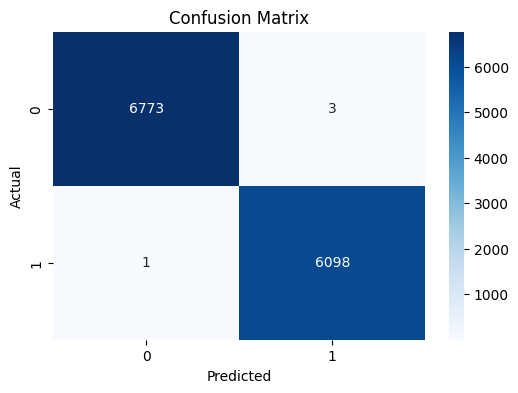

[LightGBM] [Warning] feature_fraction is set=0.9933059627875545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9933059627875545
[LightGBM] [Warning] lambda_l1 is set=2.676592466136273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.676592466136273
[LightGBM] [Warning] lambda_l2 is set=0.22473163876908597, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.22473163876908597
[LightGBM] [Warning] bagging_fraction is set=0.6525159443194917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6525159443194917
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


d:\GLT Amazon ML summer school proj\Week 1\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


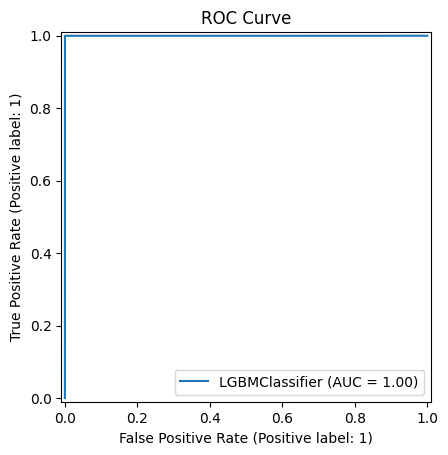

In [55]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on validation set
y_pred = final_model.predict(X_val)
y_proba = final_model.predict_proba(X_val)[:, 1]

# AUC Score
print("ROC AUC Score:", roc_auc_score(y_val, y_proba))

# Classification Report
print("Classification Report:\n", classification_report(y_val, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(final_model, X_val, y_val)
plt.title("ROC Curve")
plt.show()


### Save MODEL

In [56]:
joblib.dump(final_model, "../models/final_model_lgbm.pkl")
print("Model saved successfully!")

Model saved successfully!


### Feature importance

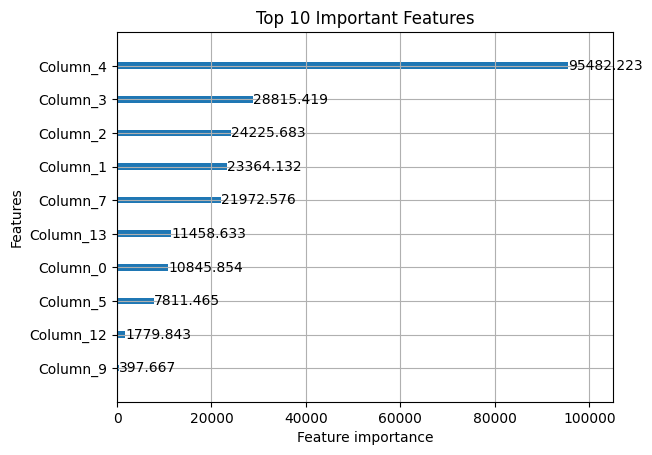

In [57]:
# Feature importance
lgb.plot_importance(final_model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Important Features")
plt.show()

##  Summary: Model Training for Churn Prediction

In this notebook, we trained a **LightGBM (LGBM)** model to predict customer churn using the preprocessed dataset from `01_preprocessing.ipynb`.

###  Steps Covered:

1. **Data Loading**  
   Loaded `X_train`, `X_val`, `y_train`, and `y_val` from the saved `.csv` files.

2. **Hyperparameter Tuning (Optuna)**  
   - Used `Optuna` for automated tuning of `LGBMClassifier` hyperparameters.  
   - The objective was to **maximize ROC AUC score** on validation data.
   - Ran for `n_trials=50` and selected the best performing set of hyperparameters.

3. **Final Model Training**  
   - Trained a `LightGBM` model using the best hyperparameters.
   - Set `random_state=42` to ensure reproducibility.

4. **Model Evaluation**
   - Evaluated the model using:
     - **ROC AUC Score**
     - **Classification Report**
     - **Confusion Matrix**
     - **ROC Curve Visualization**
   - This helped us measure the model's ability to distinguish between churned and retained customers.

5. **Model Saving**
   - Saved the final trained model as a `.pkl` file using `joblib` to the `models/` directory for reuse in prediction or deployment.

6. **Feature Importance**
   - Visualized the top 10 most important features based on information gain.

---

    This notebook prepares a high-performing churn prediction model ready for deployment or inference on unseen customer data.